In [1]:
# # RF 调制识别模型训练与评估 (使用 utils) - RAPIDS cuML
#
# 使用预处理特征训练 cuML RF 模型，并调用 utils 进行评估和绘图。

# ## 1. 导入库与环境设置

# +
# 基础库
import numpy as np
import cupy as cp
import pickle
import time
import os
import gc
import matplotlib.pyplot as plt # 仍然需要 plt 来显示图形

# RAPIDS cuML (导入 RF 和 GridSearchCV)
from cuml.ensemble import RandomForestClassifier
from cuml.model_selection import GridSearchCV
print("RAPIDS cuML 库导入成功。")

# Scikit-learn 辅助库 (导入 KFold)
from sklearn.model_selection import KFold # 从 sklearn.model_selection 导入 KFold
print("Scikit-learn 辅助库导入成功。")

# 导入自定义工具函数
import evaluation_utils
import plotting_utils
print("自定义工具函数导入成功。")

# 检查库版本
import cuml
import sklearn
print(f"RAPIDS cuML 版本: {cuml.__version__}")
print(f"Scikit-learn 版本: {sklearn.__version__}")

# 设置字体参数 (供 plotting_utils 使用)
FONT_FILENAME = "NotoSansSC-VariableFont_wght.ttf"
FONT_SUBDIR = "fonts"
MODEL_NAME = "cuML RF" # 用于图表标题

# 确保负号显示
plt.rcParams['axes.unicode_minus'] = False
# -

RAPIDS cuML 库导入成功。
Scikit-learn 辅助库导入成功。
自定义工具函数导入成功。
RAPIDS cuML 版本: 25.04.00
Scikit-learn 版本: 1.6.1


In [2]:
# ## 2. 加载预处理数据
# 加载由预处理脚本生成的特征数据、标签、SNR、映射和缩放器。

# +
data_dir = 'processed_ml_features' # 使用预处理步骤中指定的目录名
print(f"从 '{data_dir}' 加载数据...")

try:
    X_train_scaled_np = np.load(os.path.join(data_dir, 'X_train_scaled.npy'))
    X_val_scaled_np = np.load(os.path.join(data_dir, 'X_val_scaled.npy'))
    X_test_scaled_np = np.load(os.path.join(data_dir, 'X_test_scaled.npy'))
    y_train_np = np.load(os.path.join(data_dir, 'y_train.npy'))
    y_val_np = np.load(os.path.join(data_dir, 'y_val.npy'))
    y_test_np = np.load(os.path.join(data_dir, 'y_test.npy'))
    snr_test_np = np.load(os.path.join(data_dir, 'snr_test.npy'))
    label_mapping = np.load(os.path.join(data_dir, 'label_mapping.npy'), allow_pickle=True).item()
    scaler_path = os.path.join(data_dir, 'scaler.pkl')
    with open(scaler_path, 'rb') as f: scaler = pickle.load(f)

    # 提取调制类型列表和类别标签 (整数)
    mods = list(label_mapping.values())
    num_classes = len(mods)
    labels = np.arange(num_classes) # 用于评估和绘图

    print("NumPy 数据加载完成。")
    print(f"测试集形状: X={X_test_scaled_np.shape}, y={y_test_np.shape}, snr={snr_test_np.shape}")
    print(f"调制类型 ({num_classes}): {mods}")

    # --- 将需要的数据传输到 GPU (转换为 CuPy 数组) ---
    print("\n将数据转换为 CuPy 数组 (传输到 GPU)...")
    X_train_scaled = cp.asarray(X_train_scaled_np); del X_train_scaled_np # 训练特征
    X_val_scaled = cp.asarray(X_val_scaled_np);     del X_val_scaled_np   # 验证特征
    X_test_scaled = cp.asarray(X_test_scaled_np)    # 测试集保留 CuPy
    y_train = cp.asarray(y_train_np);               del y_train_np        # 训练标签
    y_val = cp.asarray(y_val_np);                   del y_val_np          # 验证标签

    # y_test 和 snr_test 保留 NumPy 版本，评估函数需要 NumPy 输入
    y_test = y_test_np
    snr_test = snr_test_np

    gc.collect() # 清理内存
    print("数据传输到 GPU 并清理 NumPy 完成。")

except FileNotFoundError as e:
    print(f"错误：加载数据失败，找不到文件: {e.filename}")
    print(f"请确保在 '{data_dir}' 目录下已生成预处理文件。")
    raise e
# -

从 'processed_ml_features' 加载数据...
NumPy 数据加载完成。
测试集形状: X=(44000, 16), y=(44000,), snr=(44000,)
调制类型 (11): [np.str_('8PSK'), np.str_('AM-DSB'), np.str_('AM-SSB'), np.str_('BPSK'), np.str_('CPFSK'), np.str_('GFSK'), np.str_('PAM4'), np.str_('QAM16'), np.str_('QAM64'), np.str_('QPSK'), np.str_('WBFM')]

将数据转换为 CuPy 数组 (传输到 GPU)...
数据传输到 GPU 并清理 NumPy 完成。


In [3]:
# # ## 3. 定义超参数搜索网格
# # 定义将用于 GridSearchCV 的随机森林参数网格。

# # +
# # 定义超参数搜索网格
# param_grid = {
#     'n_estimators': [50, 100, 150],      # 树的数量
#     'max_depth': [10, 20, 30],          # 树的最大深度
#     'max_features': ['sqrt', 1.0],  # 划分时考虑的最大特征数 ('sqrt' 或 1.0 表示所有特征)
#     'n_bins': [32, 64, 128]             # 用于连续特征分箱的数量 (cuML RF 重要参数)
# }

# # 固定参数 (不在网格中搜索的参数)
# fixed_rf_params = {
#     'random_state': 42,       # 保证可复现性
#     'n_streams': 1            # 使用的 CUDA 流数量
# }

# print("将用于 GridSearchCV 的参数网格:")
# print(param_grid)
# print("\n固定的 RF 参数:")
# print(fixed_rf_params)
# # -

In [4]:
# ## 3. RF 模型参数定义
# 定义将要手动使用的随机森林参数。

# +
# 随机森林参数
# 找到的最佳参数: {'max_depth': 20, 'max_features': 'sqrt', 'n_bins': 128, 'n_estimators': 150}
rf_params = {
    'n_estimators': 150,      # 树的数量
    'max_depth': 20,          # 树的最大深度
    'max_features': 'sqrt',   # 划分时考虑的最大特征数
    'n_bins': 128,            # 用于连续特征分箱的数量 (cuML RF 重要参数)
    'random_state': 42,       # 保证可复现性
    'n_streams': 1            # 使用的 CUDA 流数量
}

print("将使用的 RF 参数:")
print(rf_params)
# -

将使用的 RF 参数:
{'n_estimators': 150, 'max_depth': 20, 'max_features': 'sqrt', 'n_bins': 128, 'random_state': 42, 'n_streams': 1}


In [5]:
# # ## 4. 模型训练 (使用 GridSearchCV 进行超参数搜索)
# # 合并训练集和验证集，并使用 GridSearchCV 寻找最佳 cuML RF 模型参数。

# # +
# # 合并训练集和验证集 (在 GPU 上操作)
# if 'X_train_scaled' not in locals() or not isinstance(X_train_scaled, cp.ndarray): raise ValueError("训练数据 X_train_scaled 未加载或不是 CuPy 数组")
# if 'X_val_scaled' not in locals() or not isinstance(X_val_scaled, cp.ndarray): raise ValueError("验证数据 X_val_scaled 未加载或不是 CuPy 数组")
# if 'y_train' not in locals() or not isinstance(y_train, cp.ndarray): raise ValueError("训练标签 y_train 未加载或不是 CuPy 数组")
# if 'y_val' not in locals() or not isinstance(y_val, cp.ndarray): raise ValueError("验证标签 y_val 未加载或不是 CuPy 数组")

# X_train_full_cp = cp.vstack((X_train_scaled, X_val_scaled))
# y_train_full_cp = cp.concatenate((y_train, y_val))
# print(f"合并后的 GPU 训练数据形状 (CuPy): X={X_train_full_cp.shape}, y={y_train_full_cp.shape}")
# del X_train_scaled, X_val_scaled, y_train, y_val; gc.collect()

# # --- 使用 GridSearchCV 训练和搜索 ---
# print(f"\n开始使用 GridSearchCV 进行超参数搜索 (cuML RF)...")
# best_rf_model = None # 初始化最佳模型变量
# grid_search_results = None # 存储搜索结果
# start_time = time.time()

# try:
#     # 创建 cuML RF 实例 (不传入网格中的参数，但传入固定参数)
#     rf_estimator = RandomForestClassifier(**fixed_rf_params)

#     # 定义 K 折交叉验证 (使用 sklearn 的 KFold)
#     cv_splitter = KFold(n_splits=3, shuffle=True, random_state=42) # 3 折交叉验证

#     # 创建 GridSearchCV 实例
#     grid_search = GridSearchCV(
#         estimator=rf_estimator,
#         param_grid=param_grid,
#         cv=cv_splitter, # 使用 sklearn 的 KFold 实例
#         verbose=2 # 增加 verbose 以查看进度
#     )

#     # 执行网格搜索和拟合
#     grid_search.fit(X_train_full_cp, y_train_full_cp)
#     end_time = time.time()
#     training_duration = end_time - start_time
#     print(f"\nGridSearchCV 完成。总耗时: {training_duration:.2f} 秒")

#     # 获取最佳模型和参数
#     best_rf_model = grid_search.best_estimator_
#     grid_search_results = grid_search.cv_results_ # 查看详细结果
#     print(f"\n找到的最佳参数: {grid_search.best_params_}")
#     print(f"对应的最佳分数 (Accuracy): {grid_search.best_score_:.4f}")

# except Exception as e:
#     print(f"\n错误：GridSearchCV 失败: {e}")
#     best_rf_model = None
#     grid_search_results = None

# # 清理内存
# del X_train_full_cp, y_train_full_cp; gc.collect()

# # 检查模型是否成功训练
# if best_rf_model:
#     print(f"\n成功找到并训练了最佳 cuML RF 模型。")
# else:
#     print("\n警告：未能成功完成超参数搜索或训练最佳模型。后续评估将无法进行。")
# # -

In [6]:
# ## 4. 模型训练
# 合并训练集和验证集，并使用上面定义的 rf_params 训练 cuML RF 模型。

# +
# 合并训练集和验证集 (在 GPU 上操作)
if 'X_train_scaled' not in locals() or not isinstance(X_train_scaled, cp.ndarray): raise ValueError("训练数据 X_train_scaled 未加载或不是 CuPy 数组")
if 'X_val_scaled' not in locals() or not isinstance(X_val_scaled, cp.ndarray): raise ValueError("验证数据 X_val_scaled 未加载或不是 CuPy 数组")
if 'y_train' not in locals() or not isinstance(y_train, cp.ndarray): raise ValueError("训练标签 y_train 未加载或不是 CuPy 数组")
if 'y_val' not in locals() or not isinstance(y_val, cp.ndarray): raise ValueError("验证标签 y_val 未加载或不是 CuPy 数组")

X_train_full_cp = cp.vstack((X_train_scaled, X_val_scaled))
y_train_full_cp = cp.concatenate((y_train, y_val))
print(f"合并后的 GPU 训练数据形状 (CuPy): X={X_train_full_cp.shape}, y={y_train_full_cp.shape}")
del X_train_scaled, X_val_scaled, y_train, y_val; gc.collect()

# --- 直接定义并训练模型 ---
print(f"\n使用参数 {rf_params} 开始训练 cuML RF...")
best_rf_model = None # 初始化模型变量
start_time = time.time()

try:
    # 创建 cuML RF 实例并训练
    rf_model = RandomForestClassifier(**rf_params)
    rf_model.fit(X_train_full_cp, y_train_full_cp)
    end_time = time.time()
    training_duration = end_time - start_time
    print(f"\n模型训练完成。耗时: {training_duration:.2f} 秒")
    best_rf_model = rf_model # 将训练好的模型赋值

except Exception as e:
    print(f"\n错误：直接训练 cuML RF 失败: {e}")
    best_rf_model = None

# 清理内存
del X_train_full_cp, y_train_full_cp; gc.collect()

# 检查模型是否成功训练
if best_rf_model:
    print(f"\n成功训练了 cuML RF 模型。")
else:
    print("\n警告：模型未能成功训练。后续评估将无法进行。")
# -

合并后的 GPU 训练数据形状 (CuPy): X=(176000, 16), y=(176000,)

使用参数 {'n_estimators': 150, 'max_depth': 20, 'max_features': 'sqrt', 'n_bins': 128, 'random_state': 42, 'n_streams': 1} 开始训练 cuML RF...

模型训练完成。耗时: 3.40 秒

成功训练了 cuML RF 模型。


In [7]:
# ## 5. 测试集评估 - 预测
# 使用训练好的 RF 模型对测试集进行预测。

# +
all_preds_np = None # 初始化为 None
if best_rf_model: # 检查 RF 模型是否存在
    print("\n在 GPU 测试集上进行预测 (RF)...")
    start_time = time.time()
    try:
        # 确保 X_test_scaled 是 CuPy 数组
        if not isinstance(X_test_scaled, cp.ndarray): X_test_scaled = cp.asarray(X_test_scaled)
        all_preds_cp = best_rf_model.predict(X_test_scaled) # 使用 RF 模型预测
    except Exception as e:
        print(f"预测过程中发生错误: {e}")
        all_preds_cp = None # 标记预测失败

    if all_preds_cp is not None:
        end_time = time.time()
        print(f"GPU 预测完成。耗时: {end_time - start_time:.2f} 秒")
        print(f"预测结果类型: {type(all_preds_cp)}") # 预期是 cupy.ndarray

        # --- 将预测结果转为 NumPy 供评估函数使用 ---
        print("将预测结果从 CuPy 转换为 NumPy...")
        all_preds_np = cp.asnumpy(all_preds_cp)
        del all_preds_cp; gc.collect()
        print("转换完成。")

        # 验证形状 (使用 NumPy)
        assert len(all_preds_np) == len(y_test), "预测结果和真实标签长度不一致!"
        print(f"预测标签形状 (NumPy): {all_preds_np.shape}")
        print(f"真实标签形状 (NumPy): {y_test.shape}")
    else:
         print("错误：预测失败，无法继续评估。")

else:
    print("\n错误：未能成功训练或获取最佳 RF 模型，无法进行预测。")
# -


在 GPU 测试集上进行预测 (RF)...
GPU 预测完成。耗时: 0.55 秒
预测结果类型: <class 'cupy.ndarray'>
将预测结果从 CuPy 转换为 NumPy...
转换完成。
预测标签形状 (NumPy): (44000,)
真实标签形状 (NumPy): (44000,)


In [8]:
# ## 6. 计算整体性能指标 (调用 utils)
# 使用 evaluation_utils 中的函数计算整体准确率、分类报告和混淆矩阵。

# +
if all_preds_np is not None:
    # 调用工具函数计算指标
    # 确认 y_test (真实标签) 和 all_preds_np (预测标签) 都是 NumPy 数组
    # mods 是从 label_mapping 获取的调制类型名称列表
    # labels 是对应的整数标签 [0, 1, ..., num_classes-1]
    overall_accuracy, report, conf_matrix_overall_np = evaluation_utils.calculate_metrics(
        y_test, all_preds_np, mods, labels=labels
    )
    # 这些指标已在 calculate_metrics 函数内部打印输出
else:
    print("\n错误：预测结果无效，无法计算性能指标。")
# -


计算整体性能指标...
整体准确率 (Overall Accuracy): 0.5334

计算分类报告...

分类报告 (Classification Report):

              precision    recall  f1-score   support

        8PSK     0.6124    0.4052    0.4877      4000
      AM-DSB     0.5910    0.5803    0.5856      4000
      AM-SSB     0.2586    0.9503    0.4065      4000
        BPSK     0.8196    0.5680    0.6710      4000
       CPFSK     0.7522    0.5495    0.6351      4000
        GFSK     0.7921    0.5905    0.6766      4000
        PAM4     0.8601    0.6545    0.7433      4000
       QAM16     0.5017    0.3337    0.4008      4000
       QAM64     0.5610    0.4853    0.5204      4000
        QPSK     0.6074    0.4425    0.5120      4000
        WBFM     0.6244    0.3075    0.4121      4000

    accuracy                         0.5334     44000
   macro avg     0.6346    0.5334    0.5501     44000
weighted avg     0.6346    0.5334    0.5501     44000


计算整体混淆矩阵 (使用 scikit-learn)...

整体混淆矩阵 (NumPy 数组):

[[1621   18 1333   42  168   49   32  136  112

In [9]:
# ## 7. 按 SNR 计算性能指标 (调用 utils)
# 使用 evaluation_utils 中的函数计算每个 SNR 下的准确率和混淆矩阵。

# +
if all_preds_np is not None:
    # 调用工具函数计算 SNR 指标
    # y_test, all_preds_np, snr_test 都为 NumPy 数组
    snr_accuracy_dict, snr_conf_matrix_np_dict = evaluation_utils.calculate_snr_metrics(
        y_test, all_preds_np, snr_test, labels=labels
    )
    # 将准确率转换为百分比
    snr_acc_percent = {snr: acc * 100 for snr, acc in snr_accuracy_dict.items()}
    # 各 SNR 指标已在 calculate_snr_metrics 函数内部打印输出
else:
    print("\n错误：预测结果无效，无法按 SNR 计算性能指标。")
# -


按 SNR 计算性能指标...
测试集中的 SNR 值: [np.int64(-20), np.int64(-18), np.int64(-16), np.int64(-14), np.int64(-12), np.int64(-10), np.int64(-8), np.int64(-6), np.int64(-4), np.int64(-2), np.int64(0), np.int64(2), np.int64(4), np.int64(6), np.int64(8), np.int64(10), np.int64(12), np.int64(14), np.int64(16), np.int64(18)]
SNR = -20 dB: Accuracy = 0.1000, Samples = 2191
SNR = -18 dB: Accuracy = 0.0944, Samples = 2213
SNR = -16 dB: Accuracy = 0.0991, Samples = 2210
SNR = -14 dB: Accuracy = 0.1182, Samples = 2199
SNR = -12 dB: Accuracy = 0.1206, Samples = 2173
SNR = -10 dB: Accuracy = 0.1819, Samples = 2139
SNR =  -8 dB: Accuracy = 0.2932, Samples = 2186
SNR =  -6 dB: Accuracy = 0.4318, Samples = 2207
SNR =  -4 dB: Accuracy = 0.5162, Samples = 2228
SNR =  -2 dB: Accuracy = 0.6005, Samples = 2215
SNR =   0 dB: Accuracy = 0.6822, Samples = 2206
SNR =   2 dB: Accuracy = 0.7709, Samples = 2187
SNR =   4 dB: Accuracy = 0.7876, Samples = 2255
SNR =   6 dB: Accuracy = 0.8098, Samples = 2235
SNR =   8 dB: Ac


绘制整体混淆矩阵...
绘图：成功加载字体属性: Noto Sans SC (来自 /home/thunder032/RADIOML/RadioML2016.10a_RF/fonts/NotoSansSC-VariableFont_wght.ttf)


<Figure size 1000x800 with 0 Axes>

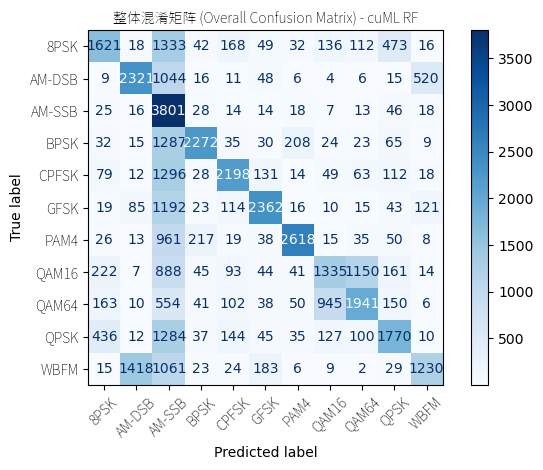

In [10]:
# ## 8. 绘制整体混淆矩阵 (调用 utils)

# +
# 检查整体混淆矩阵数据是否存在
if 'conf_matrix_overall_np' in locals() and conf_matrix_overall_np is not None:
    plotting_utils.plot_overall_cm(
        conf_matrix_overall_np, # 输入应为 NumPy 混淆矩阵
        mods,                   # 调制类型名称列表
        model_name=MODEL_NAME,  # 使用之前定义的模型名称
        font_filename=FONT_FILENAME,
        font_subdir=FONT_SUBDIR
    )
    plt.show() # 显式调用 show() 以确保在不同环境中都能显示图像
else:
    print("\n错误：整体混淆矩阵数据不存在，无法绘图。")
# -


绘制不同 SNR 下的混淆矩阵...
绘图：成功加载字体属性: Noto Sans SC (来自 /home/thunder032/RADIOML/RadioML2016.10a_RF/fonts/NotoSansSC-VariableFont_wght.ttf)
绘制包含所有 SNR 的网格混淆矩阵图...


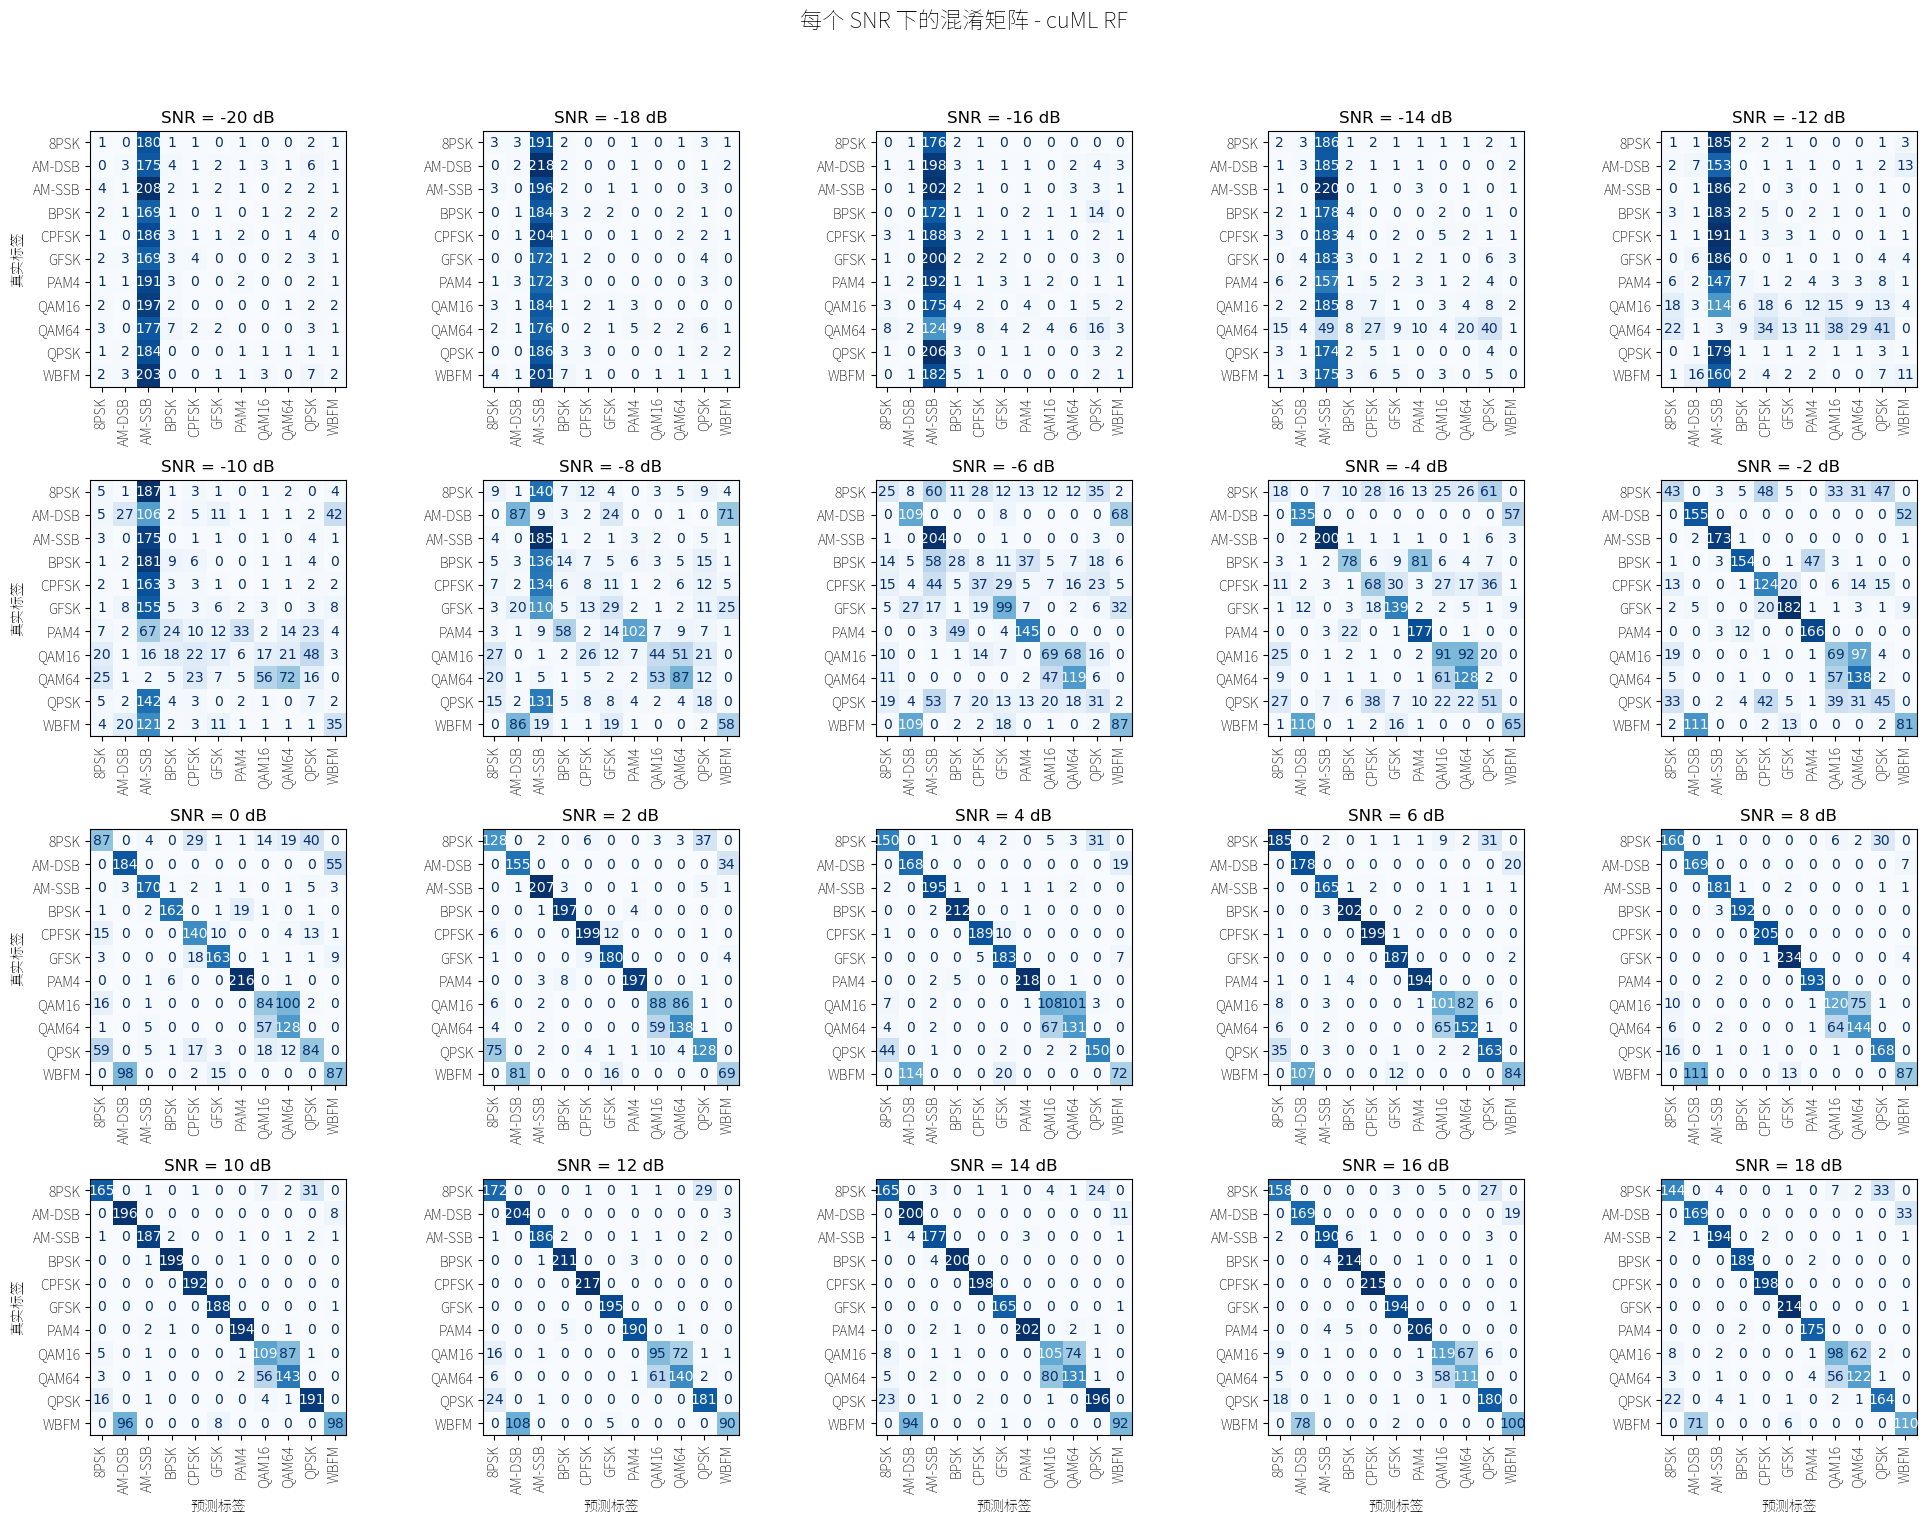

网格混淆矩阵图绘制完成。

绘制每个 SNR 的单独混淆矩阵图...
单独图像将保存到 'snr_cm_plots_cuML_RF' 目录。
已保存: snr_cm_plots_cuML_RF/cm_cuML_RF_snr_neg20dB.png
已保存: snr_cm_plots_cuML_RF/cm_cuML_RF_snr_neg18dB.png
已保存: snr_cm_plots_cuML_RF/cm_cuML_RF_snr_neg16dB.png
已保存: snr_cm_plots_cuML_RF/cm_cuML_RF_snr_neg14dB.png
已保存: snr_cm_plots_cuML_RF/cm_cuML_RF_snr_neg12dB.png
已保存: snr_cm_plots_cuML_RF/cm_cuML_RF_snr_neg10dB.png
已保存: snr_cm_plots_cuML_RF/cm_cuML_RF_snr_neg8dB.png
已保存: snr_cm_plots_cuML_RF/cm_cuML_RF_snr_neg6dB.png
已保存: snr_cm_plots_cuML_RF/cm_cuML_RF_snr_neg4dB.png
已保存: snr_cm_plots_cuML_RF/cm_cuML_RF_snr_neg2dB.png
已保存: snr_cm_plots_cuML_RF/cm_cuML_RF_snr_0dB.png
已保存: snr_cm_plots_cuML_RF/cm_cuML_RF_snr_2dB.png
已保存: snr_cm_plots_cuML_RF/cm_cuML_RF_snr_4dB.png
已保存: snr_cm_plots_cuML_RF/cm_cuML_RF_snr_6dB.png
已保存: snr_cm_plots_cuML_RF/cm_cuML_RF_snr_8dB.png
已保存: snr_cm_plots_cuML_RF/cm_cuML_RF_snr_10dB.png
已保存: snr_cm_plots_cuML_RF/cm_cuML_RF_snr_12dB.png
已保存: snr_cm_plots_cuML_RF/cm_cuML_RF_snr_14dB.png
已保存: snr

In [11]:
# ## 9. 绘制每个 SNR 下的混淆矩阵 (调用 utils)

# +
# 检查按 SNR 分组的混淆矩阵数据是否存在
if 'snr_conf_matrix_np_dict' in locals() and snr_conf_matrix_np_dict:
    plotting_utils.plot_snr_cms(
        snr_conf_matrix_np_dict, # 输入为 SNR 到 NumPy 混淆矩阵的字典
        mods,                    # 调制类型名称列表
        model_name=MODEL_NAME,   # 模型名称
        font_filename=FONT_FILENAME,
        font_subdir=FONT_SUBDIR,
        save_individual_figs=True, # 保存每个 SNR 的单独图像
        individual_fig_dir=f"snr_cm_plots_{MODEL_NAME.replace(' ', '_')}" # 指定保存目录
    )
    plt.show() # 显式调用 show() 以确保网格图显示
else:
    print("\n错误：按 SNR 的混淆矩阵数据不存在，无法绘图。")
# -


绘制 Accuracy vs. SNR 曲线...
绘图：成功加载字体属性: Noto Sans SC (来自 /home/thunder032/RADIOML/RadioML2016.10a_RF/fonts/NotoSansSC-VariableFont_wght.ttf)


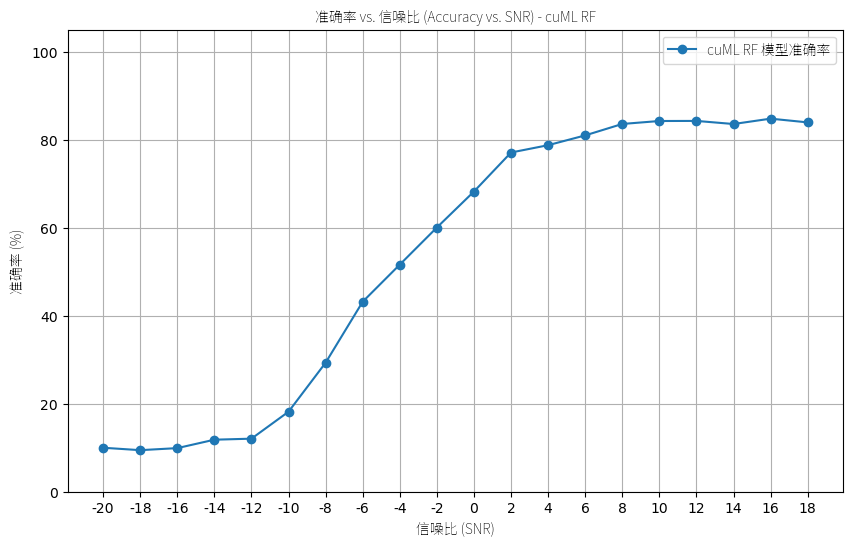

In [12]:
# ## 10. 绘制 Accuracy vs. SNR 曲线 (调用 utils)

# +
# 检查按 SNR 分组的准确率数据是否存在
if 'snr_acc_percent' in locals() and snr_acc_percent:
    plotting_utils.plot_acc_vs_snr(
        snr_acc_percent,        # 输入为 SNR 到准确率(百分比)的字典
        model_name=MODEL_NAME,  # 模型名称
        font_filename=FONT_FILENAME,
        font_subdir=FONT_SUBDIR
    )
    plt.show() # 显式调用 show()
else:
    print("\n错误：SNR 准确率数据不存在，无法绘图。")
# -

In [ ]:
# ## 11. 总结与结论
#
# 在此总结手动选择参数下 RF 模型的性能。
# - 整体准确率: [从模块 6 输出获取]
# - 高信噪比下准确率: [从模块 7 或图 10 获取]
# - 低信噪比下准确率: [从模块 7 或图 10 获取]
# - 主要混淆的类别: [从模块 8 或 9 的混淆矩阵图分析]
# - 训练/预测时间: [从模块 4 和 5 输出获取]
#
# 可以与 SVM, cnn-lstm 的性能进行对比。
#
# --- End of Notebook ---